In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing, cross_validation, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('combine_data.csv')
df.head()

,Player,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,Pfr_ID,AV,Team,Round,Pick
0,John Abraham,OLB,76,252,4.55,NaN,NaN,NaN,NaN,NaN,2000,AbraJo00,26.0,New York Jets,1.0,13.0
1,Shaun Alexander,RB,72,218,4.58,NaN,NaN,NaN,NaN,NaN,2000,AlexSh00,26.0,Seattle Seahawks,1.0,19.0
2,Darnell Alford,OT,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,AlfoDa20,0.0,Kansas City Chiefs,6.0,188.0
3,Kyle Allamon,TE,74,253,4.97,29.0,NaN,104.0,7.29,4.49,2000,NaN,0.0,NaN,NaN,NaN
4,Rashard Anderson,CB,74,206,4.55,34.0,NaN,123.0,7.18,4.15,2000,AndeRa21,6.0,Carolina Panthers,1.0,23.0


In [3]:
df.describe()

,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,AV,Round,Pick
count,6218.000000,6218.000000,6046.000000,4796.000000,4212.000000,4754.000000,3993.000000,4063.000000,6218.000000,6218.000000,3738.000000,3738.000000
mean,73.798971,243.372145,4.783784,32.818599,20.926163,113.943837,7.282307,4.390603,2009.041975,5.085719,3.838684,113.728464
std,2.621373,45.103814,0.305984,4.213729,6.393679,9.317031,0.422882,0.268836,5.471056,7.546556,1.952728,70.605155
min,65.000000,149.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000,2000.000000,-4.000000,1.000000,1.000000
25%,72.000000,206.000000,4.540000,30.000000,16.000000,108.000000,6.970000,4.190000,2004.000000,0.000000,2.000000,53.000000
50%,74.000000,233.000000,4.700000,33.000000,21.000000,115.000000,7.190000,4.350000,2009.000000,1.000000,4.000000,108.000000
75%,76.000000,281.000000,4.980000,35.500000,25.000000,121.000000,7.540000,4.560000,2014.000000,8.000000,5.000000,169.000000
max,82.000000,375.000000,6.050000,46.000000,49.000000,147.000000,9.120000,5.560000,2018.000000,51.000000,7.000000,260.000000


The data is looking great. It's time to start chopping it up and take a deeper dive. 
##### We will start by:
- Filling the missing data with an obvious outlier (-99999), because we will assume the participant either didn't participate in the combine drill or wasn't drafted.
- Creating various features to further explore the data later on in beautiful, easy to read, visualizations.
- Displaying a correlation matrix to further analyze our features.

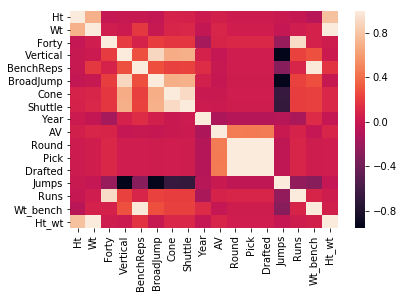

In [4]:
# filling in missing data.
df.fillna(-99999, inplace=True)

# let's start some feature engineering
df['Drafted'] = df['Round'] > 0
df['Jumps'] = df['Vertical'] * df['BroadJump']
df['Runs'] = df['Cone'] * df['Forty'] * df['Shuttle']
df['Wt_bench'] = df['Wt'] * df['BenchReps']
df['Ht_wt'] = df['Ht'] * df['Wt']
df = df.drop(['Pos', 'Player', 'Pfr_ID', 'Team'], 1)
columns = df.columns

# prepocess our data
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled)
df.columns = columns
X = df.drop(['Drafted'], 1)
y = df['Drafted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# display our correlation matrix
corr = df.corr()
sns.heatmap(corr);

Our features are looking good. There isn't too much correlation going on. Let's start building our models.

We'll start by creating a normal logistic regression model to see how it fits our data.

In [5]:
lr = LogisticRegression(penalty='l1')
fit = lr.fit(X_train, y_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_test))

print('\n Percentage accuracy')
print(lr.score(X_test, y_test))


Coefficients
[[ 0.          0.         -0.24998675  0.          0.          0.
   0.          0.          0.          0.          8.04592769  6.88434105
   0.         -0.59106955  0.          0.        ]]
[-6.03987268]

 Accuracy by admission status
Drafted  0.0  1.0
row_0            
0.0      508    0
1.0        0  736

 Percentage accuracy
1.0


Interestingly our logistic regression model is working perfectly on the train and test data.

Up next we will build our ridge regression model.

In [6]:
training_scores =[]
test_scores =[]
ridgex = np.arange(0, 10000, 500)
for xi in ridgex:
    ridge = linear_model.Ridge(alpha=xi, fit_intercept = False)
    ridge.fit(X_train, y_train)
    trainscore = ridge.score(X_train, y_train)
    testscore = ridge.score(X_test, y_test)
    training_scores.append(trainscore)
    test_scores.append(testscore)

print('\n Training accuracy')
print(training_scores)
print('\n Testing accuracy')
print(test_scores)




 Training accuracy
[0.9999999999743597, 0.9715512134566684, 0.9200971236411569, 0.8657084508984814, 0.814077233303511, 0.7666598517470601, 0.723535493919534, 0.6843422687808727, 0.6486082421436696, 0.6158702049129443, 0.5857129832302143, 0.5577782280253059, 0.5317617696720578, 0.507407208696351, 0.4844988219074075, 0.46285495745099364, 0.44232229311712645, 0.422771003614133, 0.4040907571815937, 0.3861874240895322]

 Testing accuracy
[0.9999999999756103, 0.971946857776682, 0.9214029893955836, 0.8682458936463224, 0.8180242765641472, 0.7720979772815776, 0.7304861289324251, 0.6927910266308497, 0.6585201488117283, 0.6271990732241155, 0.5984071361483922, 0.5717839689417994, 0.5470254625221371, 0.5238764974993533, 0.5021233159446842, 0.4815865844304177, 0.46211544681427813, 0.44358256561573894, 0.42588004312263983, 0.40891608636510446]


The higher the lambda, the less accurate our model is.

So far both of our models are fitting well. What about lasso regression?

In [7]:
training_scores =[]
test_scores =[]
lassx = np.arange(.01, .2, .02)
for xi in lassx:
    lass = linear_model.Lasso(alpha=xi)
    lass.fit(X_train, y_train)
    trainscore = lass.score(X_train, y_train)
    testscore = lass.score(X_test, y_test)
    training_scores.append(trainscore)
    test_scores.append(testscore)

print('\n Training accuracy')
print(training_scores)
print('\n Testing accuracy')
print(test_scores)




 Training accuracy
[0.9982505931584594, 0.9842798120533641, 0.9563328129739094, 0.9144123143547276, 0.8585183161958185, 0.7886508184971821, 0.7048098212588183, 0.6069953244807271, 0.49520732816290886, 0.3694458323053632]

 Testing accuracy
[0.998249483461149, 0.9842703687865746, 0.9563068757375404, 0.9143617244045374, 0.8584349147875658, 0.7885264468866252, 0.7046363207017159, 0.6067645362328377, 0.49491109347999074, 0.3690759924431751]


With a low lambda value our lasso model is working well indicating that most of the features are needed in order to make an accurate prediction.

All of the features that were selected seem to fit the model well, and it is predicting nicely. Any of the models would fit our dataset, and for simplicity and the sake of speed I would choose the regular logistic regression model.